# Configuração do Ambiente

Antes de começar, precisamos instalar as bibliotecas necessárias:

In [1]:
!pip install gym pygame numpy torch torchvision matplotlib

Agora, podemos importar as bibliotecas e inicializar o ambiente:

In [9]:
import gym
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

#criando o ambiente CartPole
env = gym.make ('CartPole-v1', render_mode="rgb_array")

# Verificando o numero de acoes e o tamanho do estado
state_size = env.observation_space.shape[0] # 4 estados
action_size = env.action_space.n # 2  acoes (esquerda e direita)

print(f"Estados: {state_size}, Acoes: {action_size}")
      

Estados: 4, Acoes: 2


# Criando o Agente com Deep Q-Network (DQN)

O Deep Q-Network (DQN) utiliza uma rede neural para aproximar a Q-Function, que estima o valor de cada ação possível em um estado.

## Criando a Rede Neural

<details>
<summary>Explicação do Código - Rede Neural (Q-Network)




</summary> 

Este código define uma **rede neural** que será usada como **função de aproximação de Q-values** no algoritmo **Deep Q-Network (DQN)**. A rede aprende a prever **os valores Q** das ações possíveis em um determinado estado do ambiente.

---

## **📌 Estrutura da Rede Q-Network**
O código define uma classe chamada `QNetwork`, que representa um **modelo de rede neural** construído com PyTorch.  

A estrutura da rede contém:  
✔ **Uma camada de entrada** (input layer) que recebe os estados do ambiente.  
✔ **Duas camadas ocultas** (hidden layers) com 64 neurônios cada.  
✔ **Uma camada de saída** (output layer) que retorna os valores Q para cada ação possível.  

📌 **Objetivo:** A rede recebe o estado atual como entrada e retorna **um valor Q para cada ação possível**, ajudando o agente a escolher a melhor ação.

---

## **1️⃣ Entendendo o `__init__()`**
```python
def __init__(self, state_size, action_size):
    super(QNetwork, self).__init__()
    self.fc1 = nn.Linear(state_size, 64)  # Primeira camada oculta
    self.fc2 = nn.Linear(64, 64)         # Segunda camada oculta
    self.fc3 = nn.Linear(64, action_size) # Camada de saída
```

📌 **O que está acontecendo aqui?**  
- `state_size`: Número de valores no **estado do ambiente** (CartPole tem 4).  
- `action_size`: Número de ações possíveis (CartPole tem 2: **esquerda e direita**).  
- `nn.Linear(a, b)`: Define uma **camada totalmente conectada (fully connected layer)** com `a` entradas e `b` saídas.  
- `fc1`, `fc2`, `fc3`: São **camadas lineares** da rede neural.  

---

## **2️⃣ Fluxo de Processamento (Forward Pass)**
```python
def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    return self.fc3(x)  # Retorna os valores Q para cada ação
```

📌 **Explicação passo a passo:**  
1. O estado atual é passado para a rede como **entrada**.  
2. O estado passa pela **primeira camada oculta** e é transformado por uma **função de ativação ReLU**:  
   ```python
   x = F.relu(self.fc1(state))
   ```
   - `self.fc1(state)`: Aplica a **camada linear**.  
   - `F.relu(...)`: Aplica a **função de ativação ReLU**, tornando os valores não negativos.  

3. O resultado passa pela **segunda camada oculta** e outra ativação ReLU:  
   ```python
   x = F.relu(self.fc2(x))
   ```

4. A saída passa pela **camada final (output layer)**:  
   ```python
   return self.fc3(x)
   ```
   - Essa camada **não tem ativação**, pois queremos valores contínuos para representar os **valores Q** de cada ação.  
   - O resultado é um **vetor de tamanho `action_size`**, onde cada posição representa o valor Q estimado para uma ação.  

---

## **3️⃣ Visualização da Arquitetura**  

```
Input (state) -> [4 valores]
    │
    ▼
Layer 1 (fc1): 4 → 64  (Ativação: ReLU)
    │
    ▼
Layer 2 (fc2): 64 → 64  (Ativação: ReLU)
    │
    ▼
Output Layer (fc3): 64 → action_size (2)  
[Q-value for Left, Q-value for Right]
```

✅ **Se `Q(s, esquerda)` for maior que `Q(s, direita)`, o agente escolhe a ação "esquerda".**  
✅ **Se `Q(s, direita)` for maior, o agente escolhe "direita".**  

---

## **🔍 Por que usamos ReLU?**  
A função de ativação **ReLU (Rectified Linear Unit)** é usada porque:  
✔ Impede **saturação** de gradientes (diferente de Sigmoid/Tanh).  
✔ Introduz **não linearidade**, permitindo que a rede aprenda padrões complexos.  
✔ Mantém o treinamento **eficiente e estável**.  

🔹 **Fórmula do ReLU:**  
\[
ReLU(x) = max(0, x)
\]
Isso significa que **valores negativos são convertidos para zero**, enquanto os positivos continuam inalterados.

---

## **📌 Resumo**
🔹 **A rede recebe o estado do ambiente como entrada.**  
🔹 **Passa por duas camadas ocultas com ReLU.**  
🔹 **Retorna valores Q para cada ação.**  
🔹 **O agente escolhe a ação com o maior valor Q.**  

✅ Agora que entendemos a **Q-Network**, podemos integrá-la ao agente DQN e começar o treinamento! 🚀  

🔎 **Pergunta para os alunos:**  
- O que aconteceria se **não usássemos a função de ativação ReLU**?  
- Como poderíamos melhorar essa arquitetura?    
</details> 


In [10]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Retorna os valores Q para cada ação


## Criando o Agente

<details>
    <summary> Explicação do Código - Agente DQN 🧠🤖
 </summary>
Este código define o **agente inteligente** que aprende a jogar **CartPole** usando **Deep Q-Learning (DQN)**.  
O agente toma **decisões**, **armazena experiências**, **aprende** e **melhora com o tempo**.  

Vamos entender cada parte do código de forma simples! 🚀  

---

## **1️⃣ O que é um Agente?**  

📌 O agente é o **cérebro do jogo**. Ele recebe informações do ambiente (estado), escolhe **ações** (mover o carrinho para a esquerda ou direita) e aprende com isso.  

Imagine um robô que aprende a andar de bicicleta. No começo, ele cai várias vezes, mas cada vez que tenta, **aprende um pouco mais**, até conseguir andar sem cair! 🏆  

Nosso agente faz o mesmo, mas com **CartPole**!  

---

## **2️⃣ Criando o Agente (`__init__`)**  
```python
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Memória de experiências
        self.gamma = 0.99  # Fator de desconto
        self.epsilon = 1.0  # Exploração inicial
        self.epsilon_min = 0.01  # Exploração mínima
        self.epsilon_decay = 0.995  # Taxa de decaimento do epsilon
        self.learning_rate = 0.001  # Taxa de aprendizado

        # Criando a rede neural e o otimizador
        self.model = QNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
```

### **📌 O que acontece aqui?**  
- O agente **guarda informações** sobre o jogo, como **quantos estados** ele pode observar e **quantas ações** pode tomar.  
- Ele tem uma **memória** (`deque`) que armazena jogadas passadas para **lembrar do que aprendeu**.  
- O agente tem um sistema de **exploração vs. exploração** (`epsilon`):  
  - **No início** (`epsilon = 1.0`), ele **tenta ações aleatórias** (explora).  
  - **Com o tempo**, ele usa mais o **que aprendeu** (`epsilon` vai diminuindo).  
- Ele usa uma **rede neural** (`QNetwork`) para **tomar decisões inteligentes**.  
- `optim.Adam` é o **otimizador**, que ajusta os pesos da rede para melhorar a performance.  

🎯 **Objetivo:** Criar um agente que começa aleatório e vai aprendendo **com cada jogada**.  

---

## **3️⃣ Como o Agente Escolhe Ações? (`act`)**  
```python
def act(self, state):
    """Escolhe uma ação com exploração-exploração"""
    if np.random.rand() <= self.epsilon:
        return random.choice(range(self.action_size))  # Exploração (ação aleatória)
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_values = self.model(state)
    return np.argmax(action_values.numpy())  # Escolhe a melhor ação
```

### **📌 O que acontece aqui?**  
- O agente **decide** entre **experimentar novas ações (exploração)** ou **usar o que aprendeu (exploração)**.  
- **Se `epsilon` for alto** → Escolhe uma **ação aleatória** (explorar).  
- **Se `epsilon` for baixo** → **Usa a rede neural** para prever a melhor ação.  
- Ele retorna `0` (esquerda) ou `1` (direita).  

🎯 **Objetivo:** No início, o agente explora **tentando coisas novas**, mas com o tempo, aprende **a escolher as melhores ações**.  

---

## **4️⃣ Guardando Experiências (`store_experience`)**  
```python
def store_experience(self, state, action, reward, next_state, done):
    """Armazena a experiência na memória"""
    self.memory.append((state, action, reward, next_state, done))
```

📌 **Por que armazenamos experiências?**  
- Para **lembrar** boas jogadas e aprender com erros passados.  
- O agente pode **revisar jogadas antigas** e descobrir padrões.  
- A memória ajuda no **treinamento da rede neural**.  

🎯 **Objetivo:** Criar um **banco de memórias** para que o agente **aprenda com o passado**!  

---

## **5️⃣ Treinando o Agente (`train`)**  
```python
def train(self, batch_size=64):
    """Treina a rede neural usando Replay Memory"""
    if len(self.memory) < batch_size:
        return

    batch = random.sample(self.memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones).unsqueeze(1)

    # Predições atuais
    q_values = self.model(states).gather(1, actions)

    # Calculando os valores Q-alvo
    next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
    target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

    # Função de perda e otimização
    loss = F.mse_loss(q_values, target_q_values)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # Atualiza epsilon
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay
```

### **📌 Como o agente aprende?**  
1️⃣ **Escolhe aleatoriamente um conjunto de experiências passadas** (`batch_size`).  
2️⃣ **Separa os dados**:  
   - Estado inicial  
   - Ação tomada  
   - Recompensa recebida  
   - Próximo estado observado  
   - Se o episódio terminou ou não  

3️⃣ **Calcula os valores Q** usando a **rede neural**.  
4️⃣ **Calcula os valores Q-alvo** com a fórmula do **Q-learning**:  

\[
Q(s, a) = r + \gamma \max Q(s', a')
\]

5️⃣ **Ajusta os pesos da rede neural** para diminuir a diferença entre o valor estimado e o valor real.  
6️⃣ **Reduz o `epsilon`**, fazendo o agente agir menos aleatoriamente.  

🎯 **Objetivo:** O agente aprende **a longo prazo**, usando experiências passadas para **tomar melhores decisões no futuro**.  

---

## **📌 Resumo**
🔹 O agente **armazena experiências** e usa uma **rede neural** para aprender a jogar.  
🔹 Ele equilibra **exploração** (testando ações aleatórias) e **exploração** (escolhendo a melhor ação aprendida).  
🔹 Ele treina usando **Replay Memory**, o que significa que ele aprende **com jogadas antigas** e não apenas com a última ação.  
🔹 Com o tempo, o agente melhora e consegue **manter o pêndulo equilibrado por mais tempo**! 🏆  

---

## **💡 Perguntas para Reflexão**
1. **O que aconteceria se não diminuíssemos `epsilon` com o tempo?**  
2. **Como podemos melhorar o agente para que aprenda mais rápido?**  
3. **Por que usamos uma rede neural em vez de uma tabela de valores Q?**  

Agora que entendemos como o **agente funciona**, podemos **testá-lo e visualizar os resultados!** 🚀
</details>

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)  # Memória de replay
        self.gamma = 0.99  # Fator de desconto (quanto mais alto-0.99-, mais valoriza recompensa a longo prazo)
        self.epsilon = 1.0  # Taxa de exploração inicial
        self.epsilon_min = 0.01  # Menor valor de exploração
        self.epsilon_decay = 0.997  # Taxa de decaimento do epsilon (a cada episodio o epsilon diminui por esta taxa, reduzindo a exploracao)
        self.learning_rate = 0.0005  # Taxa de aprendizado (controla a velocidade de ajuste dos pesos da rede, quanto menor for, mais estavel e lento)
        self.batch_size = 128

        # Criando a rede neural e o otimizador
        self.model = QNetwork(state_size, action_size)
        self.target_model = QNetwork(state_size, action_size)  # Rede-alvo

        # Inicializar a rede-alvo com os mesmos pesos do modelo inicial
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()  # Rede-alvo apenas faz previsões, não treina
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
   
    def update_target_model(self):
        """Atualiza a rede-alvo copiando os pesos da rede principal"""
        self.target_model.load_state_dict(self.model.state_dict())
        
    def act(self, state):
        """Escolhe uma ação com exploração-exploração"""
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))  # Exploração
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.model(state)
        return np.argmax(action_values.numpy())  # Escolhe a melhor ação

    def store_experience(self, state, action, reward, next_state, done):
        """Armazena a experiência na memória"""
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        """Treina a rede neural usando Replay Memory"""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Predições atuais
        q_values = self.model(states).gather(1, actions)

        # Calculando os valores Q-alvo
        next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Função de perda e otimização
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Atualiza epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## Treinando o Agente

Agora, vamos rodar o treinamento do agente:

<details>
<summary> Explicação do Código - Treinando o Agente DQN** 🤖🎮 </summary>  

Este código **treina um agente para jogar CartPole** usando **Deep Q-Learning (DQN)**. Além disso, ele implementa **salvamento inteligente de frames e do melhor modelo** para continuar o treinamento de onde parou.

---

## **1️⃣ Criando Pastas para Organização**
Logo no início, criamos uma **nova pasta de frames para cada execução** do script, garantindo que não sobrescrevemos frames anteriores:
```python
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
frames_dir = f"framesTrain_run_{timestamp}"
os.makedirs(frames_dir, exist_ok=True)
```
✅ O nome da pasta inclui a **data e hora da execução**, garantindo que os arquivos sejam organizados corretamente.

---

## **2️⃣ Carregando o Melhor Modelo e Estatísticas**
Antes de começar o treinamento, verificamos se **já existe um modelo salvo** e **se há informações sobre o melhor desempenho anterior**:

```python
model_path = "dqn_cartpole_best.pth"  
score_file = "best_scores.json"  

best_max_score = float('-inf')
best_mean_score = float('-inf')

if os.path.exists(score_file):
    with open(score_file, "r") as f:
        scores_data = json.load(f)
        best_max_score = scores_data.get("best_max_score", float('-inf'))
        best_mean_score = scores_data.get("best_mean_score", float('-inf'))
        print(f"📂 Pontuações carregadas: Max = {best_max_score}, Média = {best_mean_score:.2f}")
```
✅ Isso garante que o treinamento continue do **melhor modelo encontrado até o momento**.

Se um modelo já existe, carregamos os pesos:
```python
if os.path.exists(model_path):
    agent.model.load_state_dict(torch.load(model_path))
    agent.model.eval()
    print("✅ Modelo carregado com sucesso! Continuando treinamento...")
```
🔹 **Isso evita que o agente perca progresso caso o treinamento seja interrompido.**

---

## **3️⃣ Loop de Treinamento**
Agora, começamos o treinamento do agente:

```python
for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0

    for _ in range(1000):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break

    agent.train()
    scores.append(total_reward)
```
📌 O que acontece aqui?  
✅ O **agente escolhe ações**, **interage com o ambiente**, **armazena experiências** e **aprende** usando Replay Memory.  
✅ O jogo **termina quando o agente falha**, e então ele **treina a rede neural** para melhorar.  

---

## **4️⃣ Salvamento do Melhor Modelo**
A cada 100 episódios, **checamos se o agente teve a melhor pontuação** e **salvamos o modelo apenas se ele for o melhor**:
```python
if episode % 100 == 0 and len(scores) >= 100:
    last_100_scores = scores[-100:]
    max_score = max(last_100_scores)
    mean_score = np.mean(last_100_scores)

    if (max_score > best_max_score) or (max_score == best_max_score and mean_score > best_mean_score):
        best_max_score = max_score
        best_mean_score = mean_score
        torch.save(agent.model.state_dict(), model_path)

        with open(score_file, "w") as f:
            json.dump({"best_max_score": best_max_score, "best_mean_score": best_mean_score}, f)

        print(f"🏆 Novo melhor modelo salvo! Episódio {episode+1} | Máximo: {max_score} | Média: {mean_score:.2f}")
```
🔹 **Critério para salvar o modelo**:
1. Se a **pontuação máxima** dos últimos 100 episódios for maior, **salvamos o modelo**.
2. Se a pontuação máxima for igual, **olhamos para a média** e salvamos se for melhor.

✅ **Isso evita que o modelo seja sobrescrito por uma versão pior!**

---

## **5️⃣ Gráfico e Salvamento de Frames**
A cada episódio, **atualizamos o gráfico** e **salvamos um frame na pasta exclusiva desta execução**:

```python
clear_output(wait=True)
plt.figure(figsize=(8, 4))
plt.plot(x_values, smoothed_scores, label="Média Móvel (100 episódios)", color='blue', linewidth=2)
plt.fill_between(x_values, min_scores, max_scores, color='gray', alpha=0.3, label="Intervalo (Mín-Máx)")
plt.xlabel('Episódios')
plt.ylabel('Pontuação')
plt.title(f'Desempenho do Agente - Episódio {episode+1}')
plt.legend()
display(plt.gcf())  

# Salvar frame numerado na nova pasta
frame_path = os.path.join(frames_dir, f"frame_{episode:04d}.png")
plt.savefig(frame_path)
plt.close()
```
✅ Isso mantém **um único gráfico atualizado no Jupyter Notebook**.  
✅ Também **salvamos os gráficos como imagens numeradas** para criar um vídeo depois.  

---

## **6️⃣ Finalizando o Treinamento**
Quando o treinamento termina, o código informa onde os arquivos foram salvos:
```python
print(f"✅ Treinamento Finalizado. Melhor modelo salvo em {model_path}. Todos os frames salvos em {frames_dir}/")
```
✅ Agora, **o modelo pode ser reutilizado no futuro**.  
✅ **Os frames ficam organizados por execução**, sem sobrescrever os anteriores.  

---

## **📌 Conclusão**
Este código **garante que o agente continue aprendendo do melhor modelo já treinado**, além de **organizar os frames de forma separada para cada execução**.  

🔹 **Principais melhorias**:
✔ O **melhor modelo é salvo automaticamente** e carregado no próximo treinamento.  
✔ **Pontuações máximas e médias são armazenadas** para referência futura.  
✔ **Os gráficos são exibidos no Jupyter e salvos como frames**, prontos para serem convertidos em um vídeo.  
✔ **Cada execução tem sua própria pasta**, evitando sobrescrever arquivos antigos.  

Agora, o treinamento está **automatizado, organizado e eficiente**! 🚀📈
</details>

In [12]:
agent = DQNAgent(state_size, action_size)

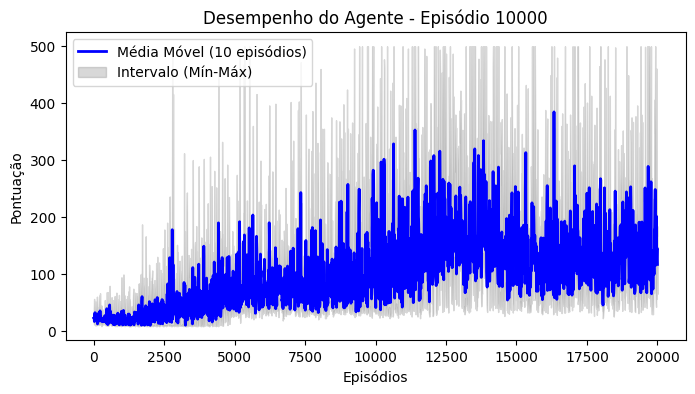

✅ Treinamento Finalizado. Melhor modelo salvo em dqn_cartpole_best.pth. Todos os frames salvos em framesTrain_run_20250212_120912/


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import json
import datetime
from IPython.display import clear_output, display

# Criar uma pasta única para cada execução
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
frames_dir = f"framesTrain_run_{timestamp}"
os.makedirs(frames_dir, exist_ok=True)

model_path = "dqn_cartpole_best.pth"  # Caminho do melhor modelo salvo
score_file = "best_scores.json"  # Arquivo para salvar best_max_score e best_mean_score

# Inicializar pontuações máximas e médias
best_max_score = float('-inf')
best_mean_score = float('-inf')

# **Carregar pontuações anteriores se existirem**
if os.path.exists(score_file):
    with open(score_file, "r") as f:
        scores_data = json.load(f)
        best_max_score = scores_data.get("best_max_score", float('-inf'))
        best_mean_score = scores_data.get("best_mean_score", float('-inf'))
        print(f"📂 Pontuações carregadas: Max = {best_max_score}, Média = {best_mean_score:.2f}")

# Criar ou carregar o agente
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Carregar o modelo salvo, se existir
if os.path.exists(model_path):
    agent.model.load_state_dict(torch.load(model_path))
    agent.model.eval()  # Coloca o modelo em modo de avaliação
    print("✅ Modelo carregado com sucesso! Continuando treinamento...")

episodes = 10000
window_size = 10
update_target_every = window_size
scores = []


for episode in range(episodes):
    state = env.reset()[0]
    total_reward = 0

    for _ in range(501):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)  # Corrigindo a conversão
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break

    agent.train()
    scores.append(total_reward)

    # **Salvar modelo apenas a cada 100 episódios**
    if episode % window_size == 0:
        agent.update_target_model()
        print(f"🔄 Rede-alvo atualizada no episódio {episode}")
        
        if len(scores) >= window_size:
            last_100_scores = scores[-window_size:]  # Pegamos os últimos 100 episódios
            max_score = max(last_100_scores)
            mean_score = np.mean(last_100_scores)

        # Critério para salvar o melhor modelo
        if (max_score > best_max_score) or (max_score == best_max_score and mean_score > best_mean_score):
            best_max_score = max_score
            best_mean_score = mean_score
            torch.save(agent.model.state_dict(), model_path)

            # **Salvar pontuações em um arquivo**
            with open(score_file, "w") as f:
                json.dump({"best_max_score": best_max_score, "best_mean_score": best_mean_score}, f)

            print(f"🏆 Novo melhor modelo salvo! Episódio {episode+1} | Máximo: {max_score} | Média: {mean_score:.2f}")

    scores.append(total_reward)
    if len(scores) >= window_size:
        num_windows = len(scores) // window_size  # Quantidade de janelas completas
        smoothed_scores = [np.mean(scores[i * window_size:(i + 1) * window_size]) for i in range(num_windows)]
        min_scores = [np.min(scores[i * window_size:(i + 1) * window_size]) for i in range(num_windows)]
        max_scores = [np.max(scores[i * window_size:(i + 1) * window_size]) for i in range(num_windows)]

        # Criar eixo X correspondente
        x_values = list(range(window_size, (num_windows + 1) * window_size, window_size))

        # Atualizar gráfico no Notebook
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))
        plt.plot(x_values, smoothed_scores, label=f"Média Móvel ({window_size} episódios)", color='blue', linewidth=2)
        plt.fill_between(x_values, min_scores, max_scores, color='gray', alpha=0.3, label="Intervalo (Mín-Máx)")
        plt.xlabel('Episódios')
        plt.ylabel('Pontuação')
        plt.title(f'Desempenho do Agente - Episódio {episode+1}')
        plt.legend()
        display(plt.gcf())  # Mostrar o gráfico no Notebook

        # Salvar frame numerado na nova pasta
        frame_path = os.path.join(frames_dir, f"frame_{episode:04d}.png")  # Exemplo: frame_0001.png
        plt.savefig(frame_path)
        plt.close()

    if episode % 10 == 0:  # Mostrar progresso a cada 10 episódios
        print(f"🔄 Episódio {episode}/{episodes} - Última pontuação: {total_reward}")

print(f"✅ Treinamento Finalizado. Melhor modelo salvo em {model_path}. Todos os frames salvos em {frames_dir}/")


In [18]:
print("Pesos do primeiro layer antes de jogar:")
print(agent.model.fc1.weight[:5])  # Exibe algumas conexões


Pesos do primeiro layer antes de jogar:
tensor([[ 1.0288,  0.4290, -0.5776, -0.1479],
        [-0.4857, -0.3552,  0.5345, -0.1979],
        [-0.0642, -0.0165, -0.3260, -0.5373],
        [-0.6897,  0.0260,  1.3219,  0.3139],
        [-0.4574,  0.0094, -0.8867, -0.2539]], grad_fn=<SliceBackward0>)


In [23]:
state = env.reset()[0]
state_tensor = torch.FloatTensor(state).unsqueeze(0)  # Converter corretamente

with torch.no_grad():
    q_values = agent.model(state_tensor)

print("Valores Q gerados pelo modelo carregado:", q_values.numpy())


Valores Q gerados pelo modelo carregado: [[17.329926 17.365824]]


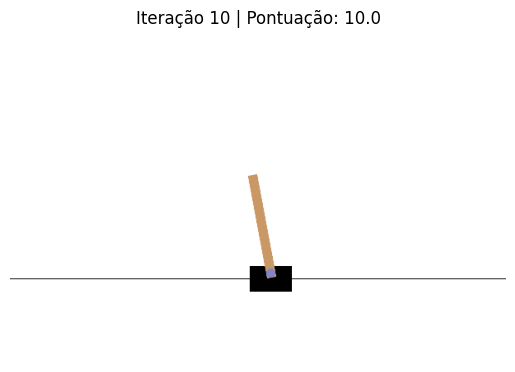

✅ Iteração 10 finalizada. Pontuação: 10.0
✅ Simulação finalizada! Frames salvos em 'simulation_20250212_131048'


In [24]:
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, clear_output

model_path = "dqn_cartpole_best.pth"  # Nome do modelo salvo

# Se existir um modelo salvo, carregar os pesos antes de rodar a simulação
if os.path.exists(model_path):
    agent.model.load_state_dict(torch.load(model_path))
    agent.model.eval()  # Modo de avaliação (evita atualizações nos pesos)
    agent.episilon = 0.01
    print("✅ Último modelo salvo carregado com sucesso!")
    input("press enter")
else:
    print("⚠️ Nenhum modelo salvo encontrado. Usando modelo inicial.")
    
# Criar pasta com timestamp para salvar os frames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
frames_dir = f"simulation_{timestamp}"
os.makedirs(frames_dir, exist_ok=True)

for i in range(10):  # 10 iterações
    state = env.reset()[0]
    done = False
    total_reward = 0
    frame_counter = 0  # Contador de frames

    while not done:
        frame = env.render()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = agent.model(state_tensor)
        action = np.argmax(action_values.numpy())  # Escolhe sempre a melhor ação
        # action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)  # Corrigindo a conversão
        total_reward += reward

        # Atualizar visualização no notebook
        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Iteração {i+1} | Pontuação: {total_reward}")
        display(plt.gcf())

        # Salvar frame numerado
        frame_path = os.path.join(frames_dir, f"iter_{i+1}_frame_{frame_counter:04d}.png")
        plt.savefig(frame_path)
        plt.close()
        
        frame_counter += 1

    # Salvar o último frame 10 vezes
    for j in range(10):
        last_frame_path = os.path.join(frames_dir, f"iter_{i+1}_last_frame_{j:02d}.png")
        plt.imsave(last_frame_path, frame)

    print(f"✅ Iteração {i+1} finalizada. Pontuação: {total_reward}")

    time.sleep(1)  # Pausa de 1s antes da próxima iteração

env.close()
print(f"✅ Simulação finalizada! Frames salvos em '{frames_dir}'")
